In [3]:

import torch
from matplotlib.patches import Circle
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline
import os, sys
import copy

sys.path.append('../')

from models import (
    AE,
    IRAE    
)

from models.modules import (
    FC_vec,
)

from bezier import Bezier, demo2bezier, bezier2traj, bezier_Riemannian_metric

from loader.Toy_dataset2 import Toy2 
from models import load_pretrained

from sklearn.mixture import GaussianMixture

from models.gmm_estimator import sqrt_SPD

device = f'cuda:0'

seed = 2023
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

In [14]:
mode = 'mmp' # mmp, immp-i, immp-c

if mode == 'mmp':
    ae, cfg = load_pretrained(
        root='../results/toy2/exp4', 
        identifier='ae_zdim5_regnone_seed1',
        ckpt_file='model_best.pkl',
        config_file='ae.yml'    
        )
    gmmest, cfg = load_pretrained(
        root='../results/toy2/exp4/ae_zdim5_regnone_seed1', 
        identifier='1',
        ckpt_file='model_best.pkl',
        config_file='ae.yml'    
        )
elif mode == 'immp-i':    
    ae, cfg = load_pretrained(
        root='../results/toy2/exp4', 
        identifier='irae_zdim5_reg0.1_seed1',
        ckpt_file='model_best.pkl',
        config_file='irae.yml'    
        )
    gmmest, cfg = load_pretrained(
        root='../results/toy2/exp4/irae_zdim5_reg0.1_seed1', 
        identifier='1',
        ckpt_file='model_best.pkl',
        config_file='irae.yml'    
        )
elif mode == 'immp-c':
    ae, cfg = load_pretrained(
        root='../results/toy2/exp4', 
        identifier='irae-bezier_zdim5_reg0.1_seed1',
        ckpt_file='model_best.pkl',
        config_file='irae-bezier.yml'    
        )
    gmmest, cfg = load_pretrained(
        root='../results/toy2/exp4/irae-bezier_zdim5_reg0.1_seed1', 
        identifier='1',
        ckpt_file='model_best.pkl',
        config_file='irae-bezier.yml'    
        )

In [15]:
ds = Toy2(root='../datasets/EXP4/')

# Env setting
workspace = [[-1, 1], [-1, 1]]
goal = [-0.8, -0.8]

Toy2 split training | torch.Size([132, 20])


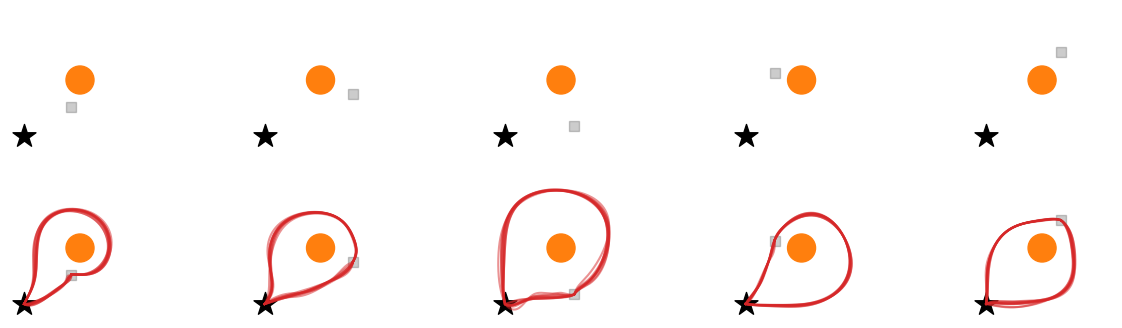

<Figure size 640x480 with 0 Axes>

In [23]:
fig, axs = plt.subplots(2, 5, figsize=(15, 4))
for i in range(5):
    tau = -0.8 + 1.6*torch.rand(1, 2)
    rad = torch.norm(tau, dim=1)
    if rad < 0.4:
        tau = tau/rad*0.4

    mu, cov = gmmest(tau) # 1, 2, 5 and 1, 2, 5, 5
    num_samples = 20
    rand_samples = torch.randn(num_samples, 5) 
    sample_z = torch.cat([
        (sqrt_SPD(cov[:, 0])@rand_samples[:int(num_samples/2)].unsqueeze(-1)).squeeze(-1) + mu[:, 0],
        (sqrt_SPD(cov[:, 1])@rand_samples[:int(num_samples/2)].unsqueeze(-1)).squeeze(-1) + mu[:, 1]
    ])

    # sampling
    sample_x = ae.decode(
        sample_z.clone().detach(), 
        tau[0].repeat(len(sample_z), 1))  
    sampled_trajs = bezier2traj(
        sample_x, 2, 1, traj_len=500).detach().cpu()

    for k in range(2):
        for init in tau:
            axs[k, i].set_xlim(workspace[0])
            axs[k, i].set_ylim(workspace[1])
            axs[k, i].set_aspect('equal')
            axs[k, i].axis('off')
            axs[k, i].scatter(init[0], init[1], marker='s', s=50, c='k', alpha=0.2)
            axs[k, i].scatter(goal[0], goal[1], marker='*', s=300, c='k')
            Obs = Circle(xy=[0,0], radius=0.2, color='tab:orange')
            axs[k, i].add_patch(Obs)

    for traj in sampled_trajs:
        axs[1, i].plot(traj[:,0], traj[:,1], c='tab:red', alpha=0.5)
            
    axs[0, i].axis('off')
plt.show()
plt.tight_layout()